## 

In [179]:
from math import log
import operator
import math
import random
import string
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import time

In [3]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)  ## 获得样本总数，这里是列表的行数
    labelCounts = {}           ## 创建分类标签变量，键值对形式
    for featVec in dataSet:   ## 循环list里每一个元素
        currentLabel = featVec[-1]                    ## 从某一个list元素的最后一个元素取值，这个值是分类标签
        if currentLabel not in labelCounts.keys():   ## 判断该分类标签是否不在labelCounts里
            labelCounts[currentLabel] = 0             ## 如果没有，那么labelCounts变量增加一个键值对 
        labelCounts[currentLabel] += 1                ## 如果已经有了，那么labelCounts变量已有键值递增
    shannonEnt = 0.0           ## 初始化香农熵
    for key in labelCounts:   ## 循环labelCounts里所有的key，有几个键值对就有几个key
        prob = float(labelCounts[key])/numEntries   ## 计算后验概率，用key除以样本总量numEntries
        shannonEnt -= prob*log(prob,2)              ## -=即迭代表示，相当于 shannonEnt = shannonEnt - prob*log(prob,2)
    return shannonEnt         ## 返回香农熵的值

In [4]:
def createDataSet(nrow,ncol):
    import random
    import string
    dataSet =   [[] for i in range(nrow)]
   
    for i in range(nrow):
        dataSet[i] = [ random.randint(0,1) for j in range(ncol) ]
    
    labels = []
    for m in range(26):
        for n in range(10):
            labels.append(string.ascii_lowercase[m]+string.digits[n])
    labels = labels[:ncol]
    
    return dataSet, labels

## 按照给定特征划分数据集

In [5]:
def splitDataSet(dataSet, axis, value):             ## axis代表第i个变量，value表示逻辑变量的值
    retDataSet = []   ##创建一个新的list
    for featVec in dataSet:                         ## 遍历每一个特征元素
        if featVec[axis] == value:                  ## 判断第i个特征的逻辑值为0或1
            reducedFeatVec = featVec[:axis]         ## 将第i个特征之前的特征值另存
            reducedFeatVec.extend(featVec[axis+1:]) ## 将第i个特征之后的特征值另存，这两行相当于把已判断的特征去掉
            retDataSet.append(reducedFeatVec)       ## 在retDataSet追加判断好的数据
    return retDataSet


## 3-3 MIG

In [6]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob*calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature,bestInfoGain

## 递归构建决策树

In [7]:
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys(): 
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(),key = operator.itemgetter(1), reverse = True)
    return sortedClassCount[0][0]

## 3-4

In [8]:
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    global MIG

    bestFeat,MIG = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    #featLabels.append(bestFeatLabel)
    myTree = {}
    myTree = { bestFeatLabel:{} }
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
        
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet,bestFeat,value), subLabels)
        
    return myTree

In [9]:
def find_max_layer(d):
    return max(find_max_layer(v) if isinstance(v, dict) else 0 for v in d.values()) + 1

## 给定候选匹配数量 = 10^2，语言粒度ncol递增

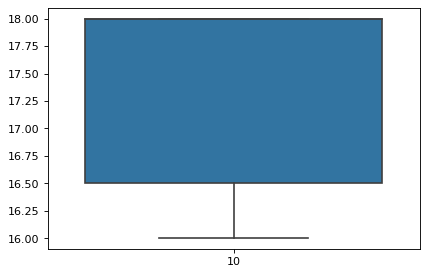

In [231]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 10

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect = depth_count

plt.figure(dpi = 80)
sns.boxplot( data = depth_collect )
plt.show()

end_time = time.process_time()
run_time = [end_time - start_time]
# run_time = run_time.extend([end_time - start_time])

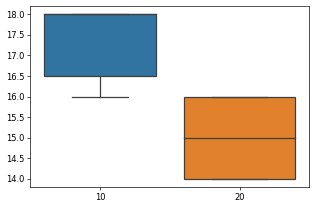

In [232]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 20

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

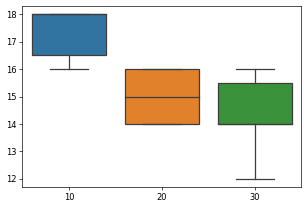

In [233]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 30

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

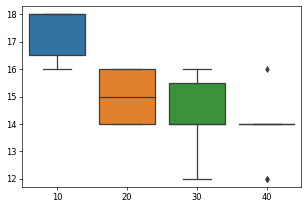

In [234]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 40

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

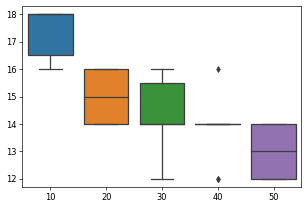

In [235]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 50

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

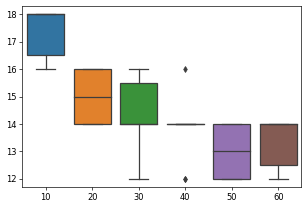

In [236]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 60

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

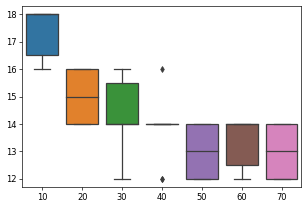

In [237]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 70

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

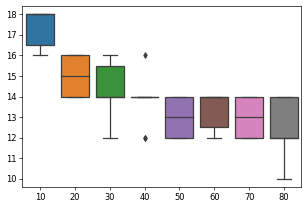

In [238]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 80

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

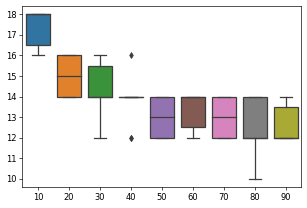

In [239]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 90

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

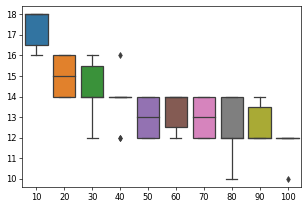

In [240]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 100

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

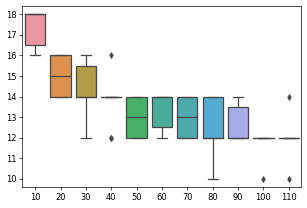

In [241]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 110

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

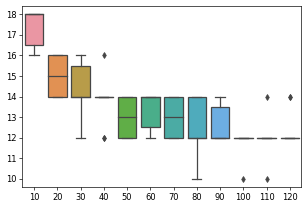

In [242]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 120

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

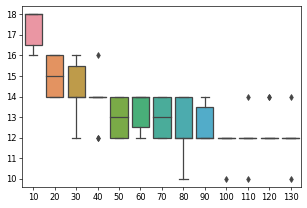

In [243]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 130

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

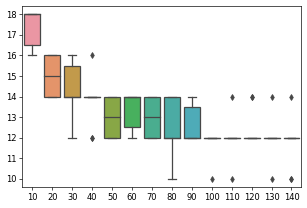

In [244]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 140

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

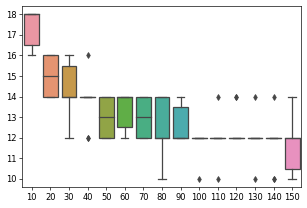

In [245]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 150

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

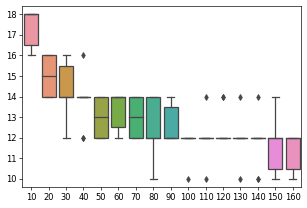

In [246]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 160

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

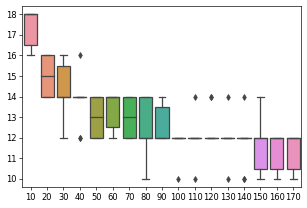

In [247]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 170

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

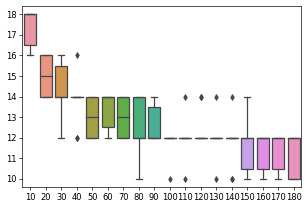

In [248]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 180

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

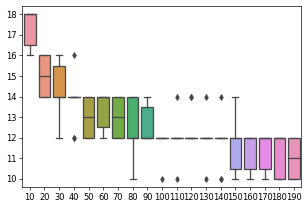

In [249]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 190

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

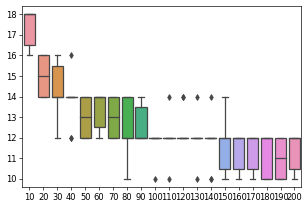

In [250]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**2
ncol = 200

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

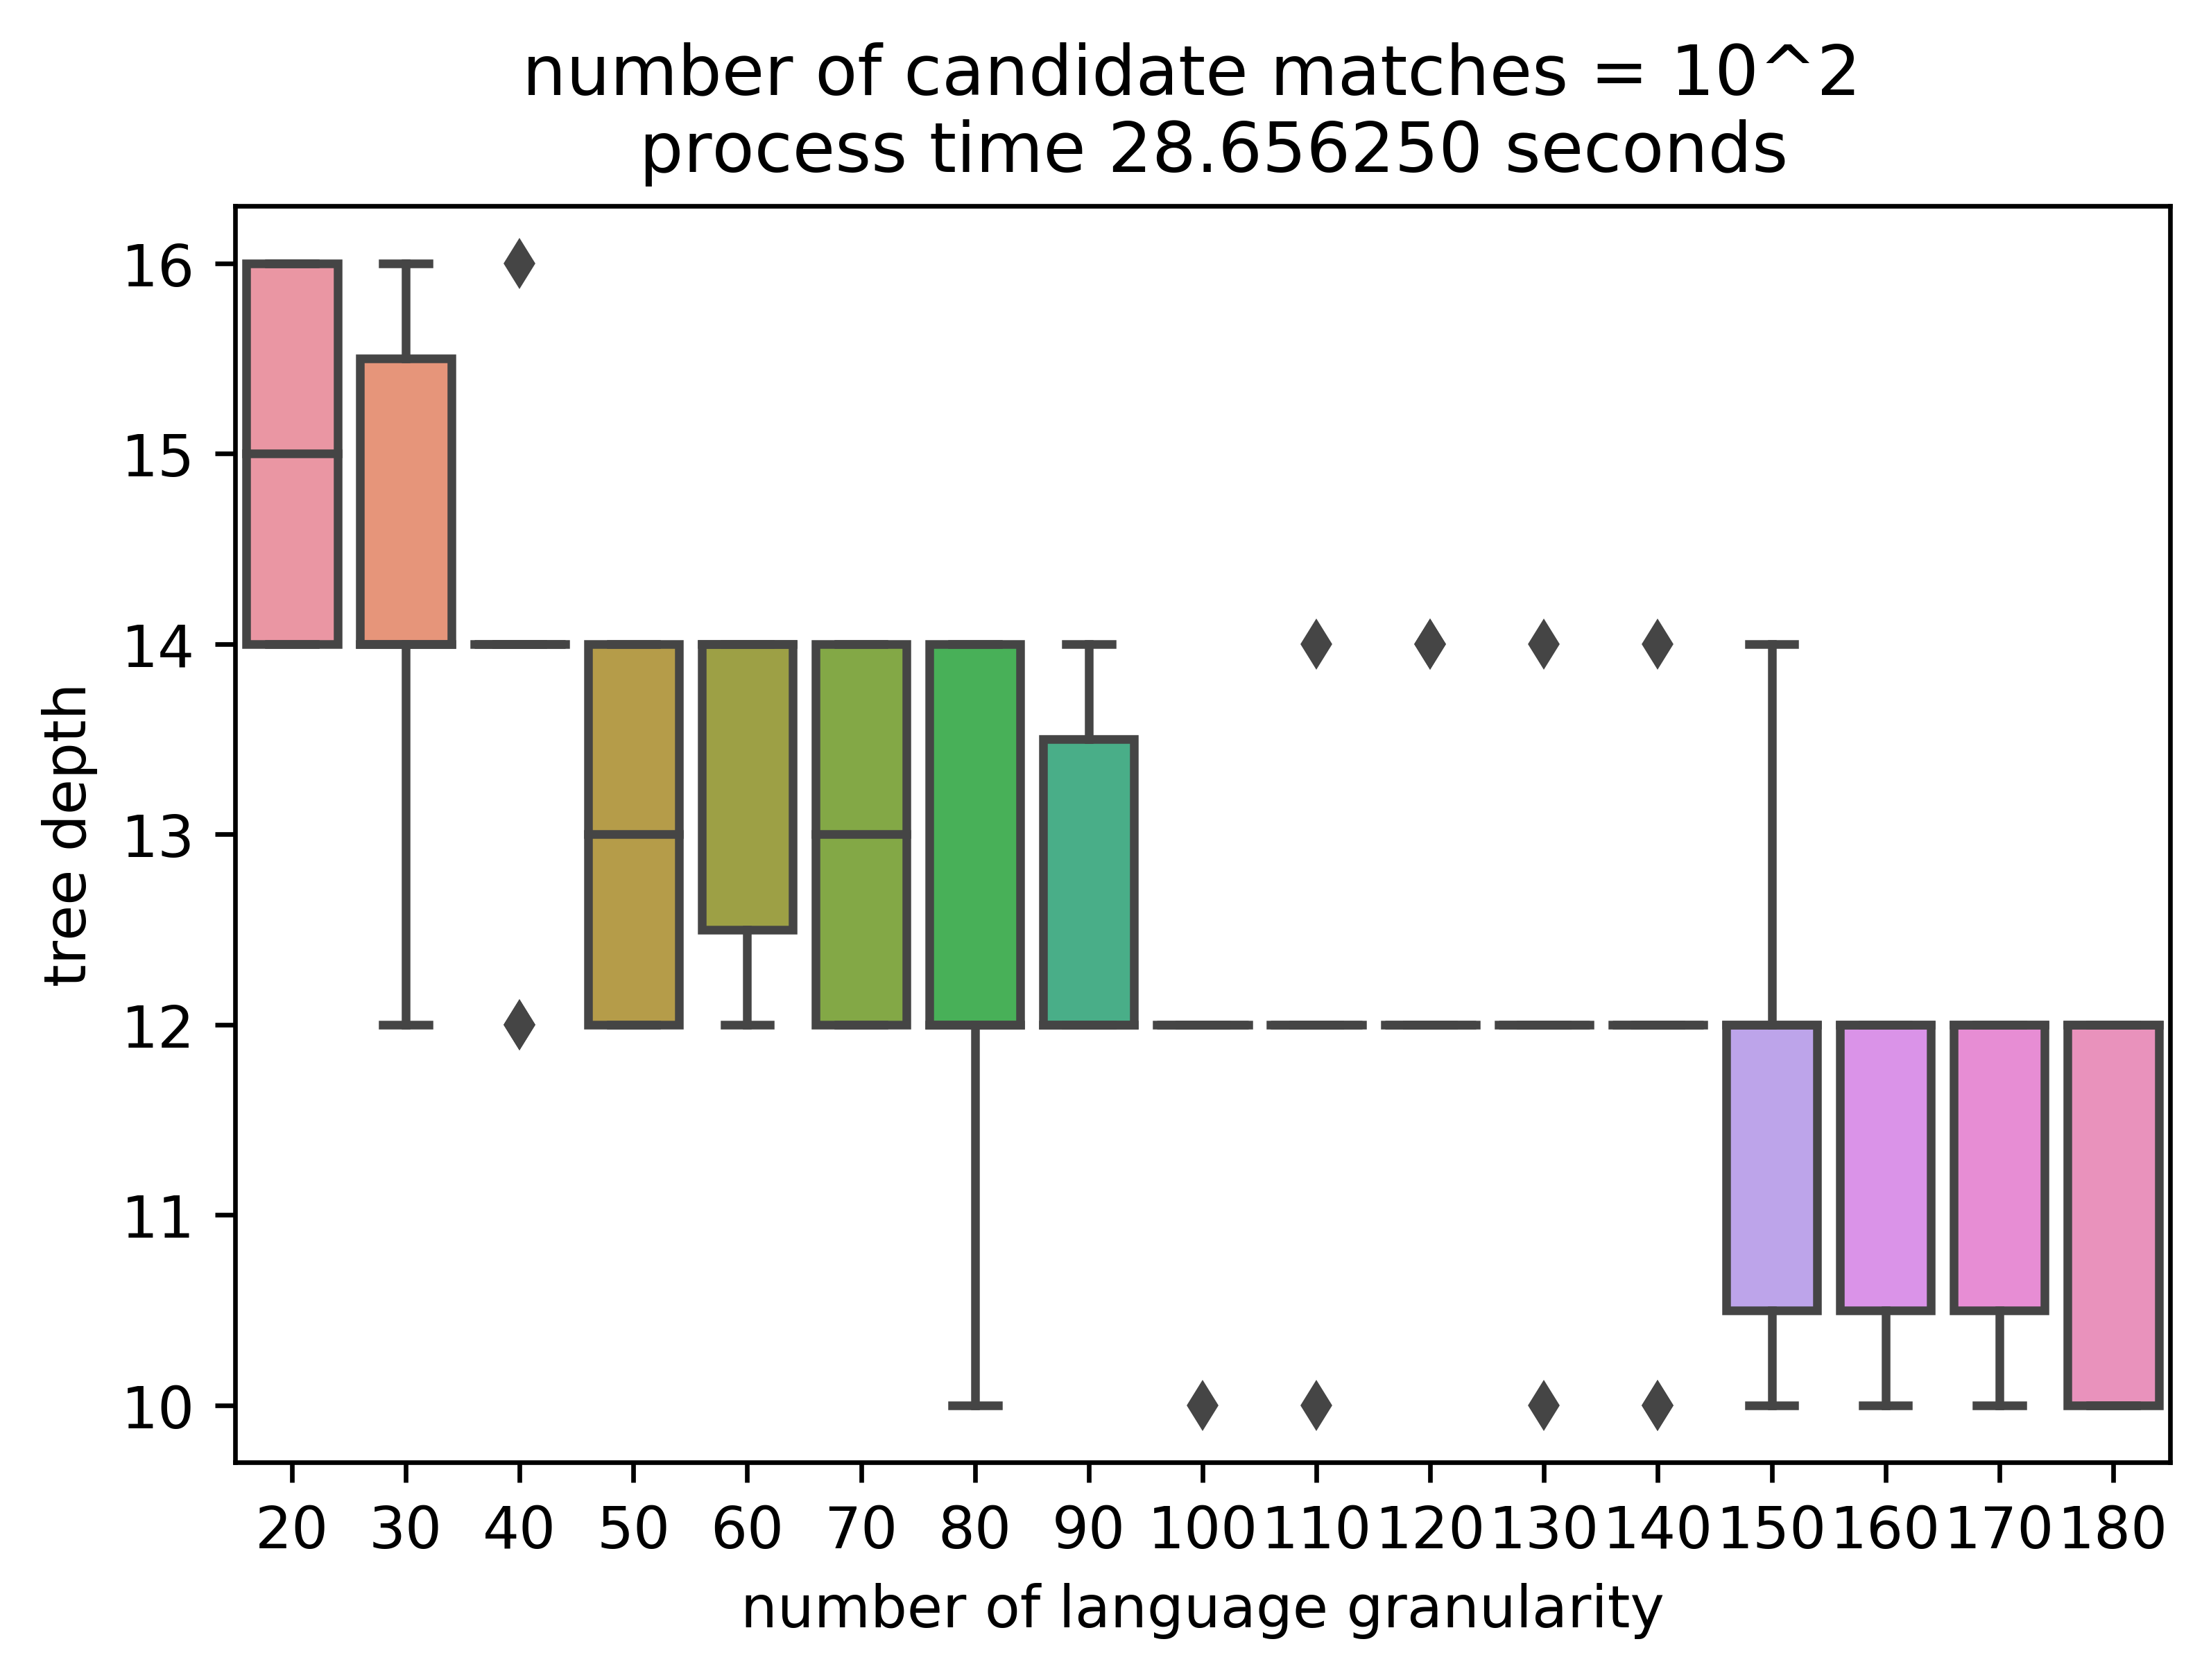

In [251]:
plt.figure(dpi = 600)
sns.boxplot( data = depth_collect.iloc[:,1:18] )
plt.xlabel('number of language granularity')
plt.ylabel('tree depth')
plt.title('number of candidate matches = 10^2 \n process time %f seconds' %sum(run_time))
plt.show()

## 给定候选匹配数量 = 10^3，语言粒度ncol递增

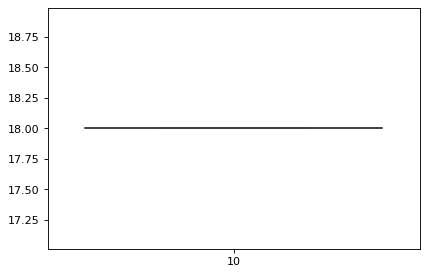

In [253]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 10

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect = depth_count

plt.figure(dpi = 80)
sns.boxplot( data = depth_collect )
plt.show()

end_time = time.process_time()
run_time = [end_time - start_time]
# run_time = run_time.extend([end_time - start_time])

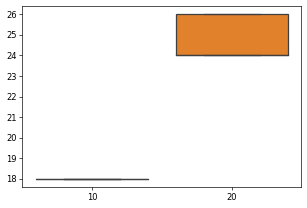

In [254]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 20

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

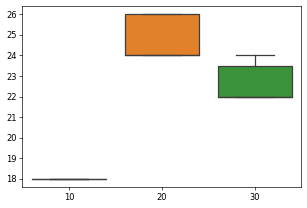

In [255]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 30

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

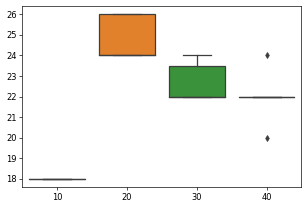

In [256]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 40

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

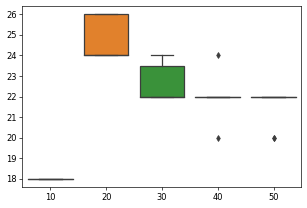

In [257]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 50

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

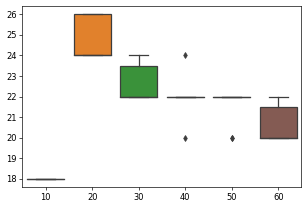

In [258]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 60

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

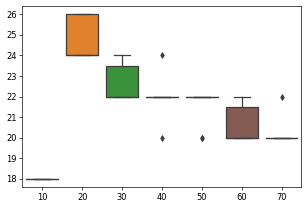

In [259]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 70

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

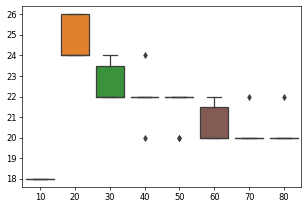

In [260]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 80

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

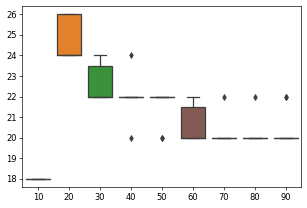

In [261]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 90

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

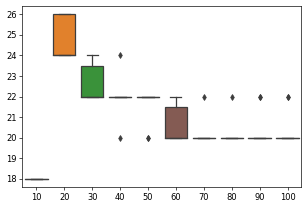

In [262]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 100

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

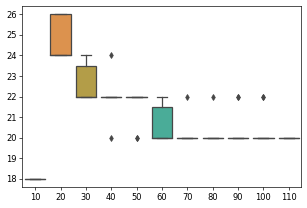

In [263]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 110

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

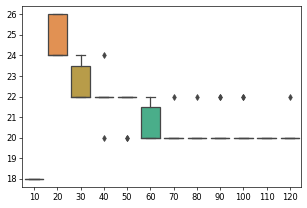

In [264]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 120

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

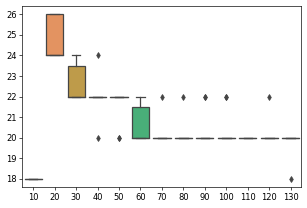

In [265]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 130

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

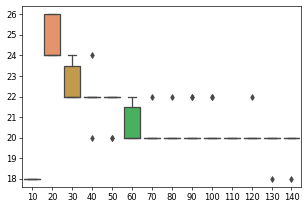

In [266]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 140

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

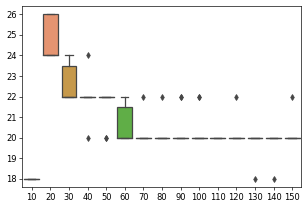

In [267]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 150

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

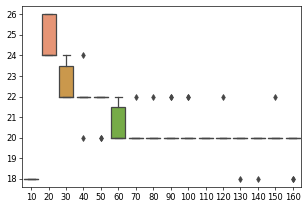

In [268]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 160

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

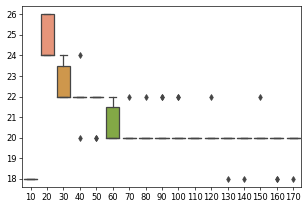

In [269]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 170

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

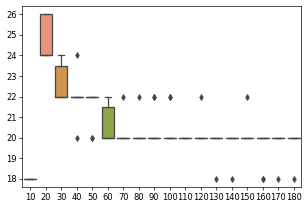

In [270]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**3
ncol = 180

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

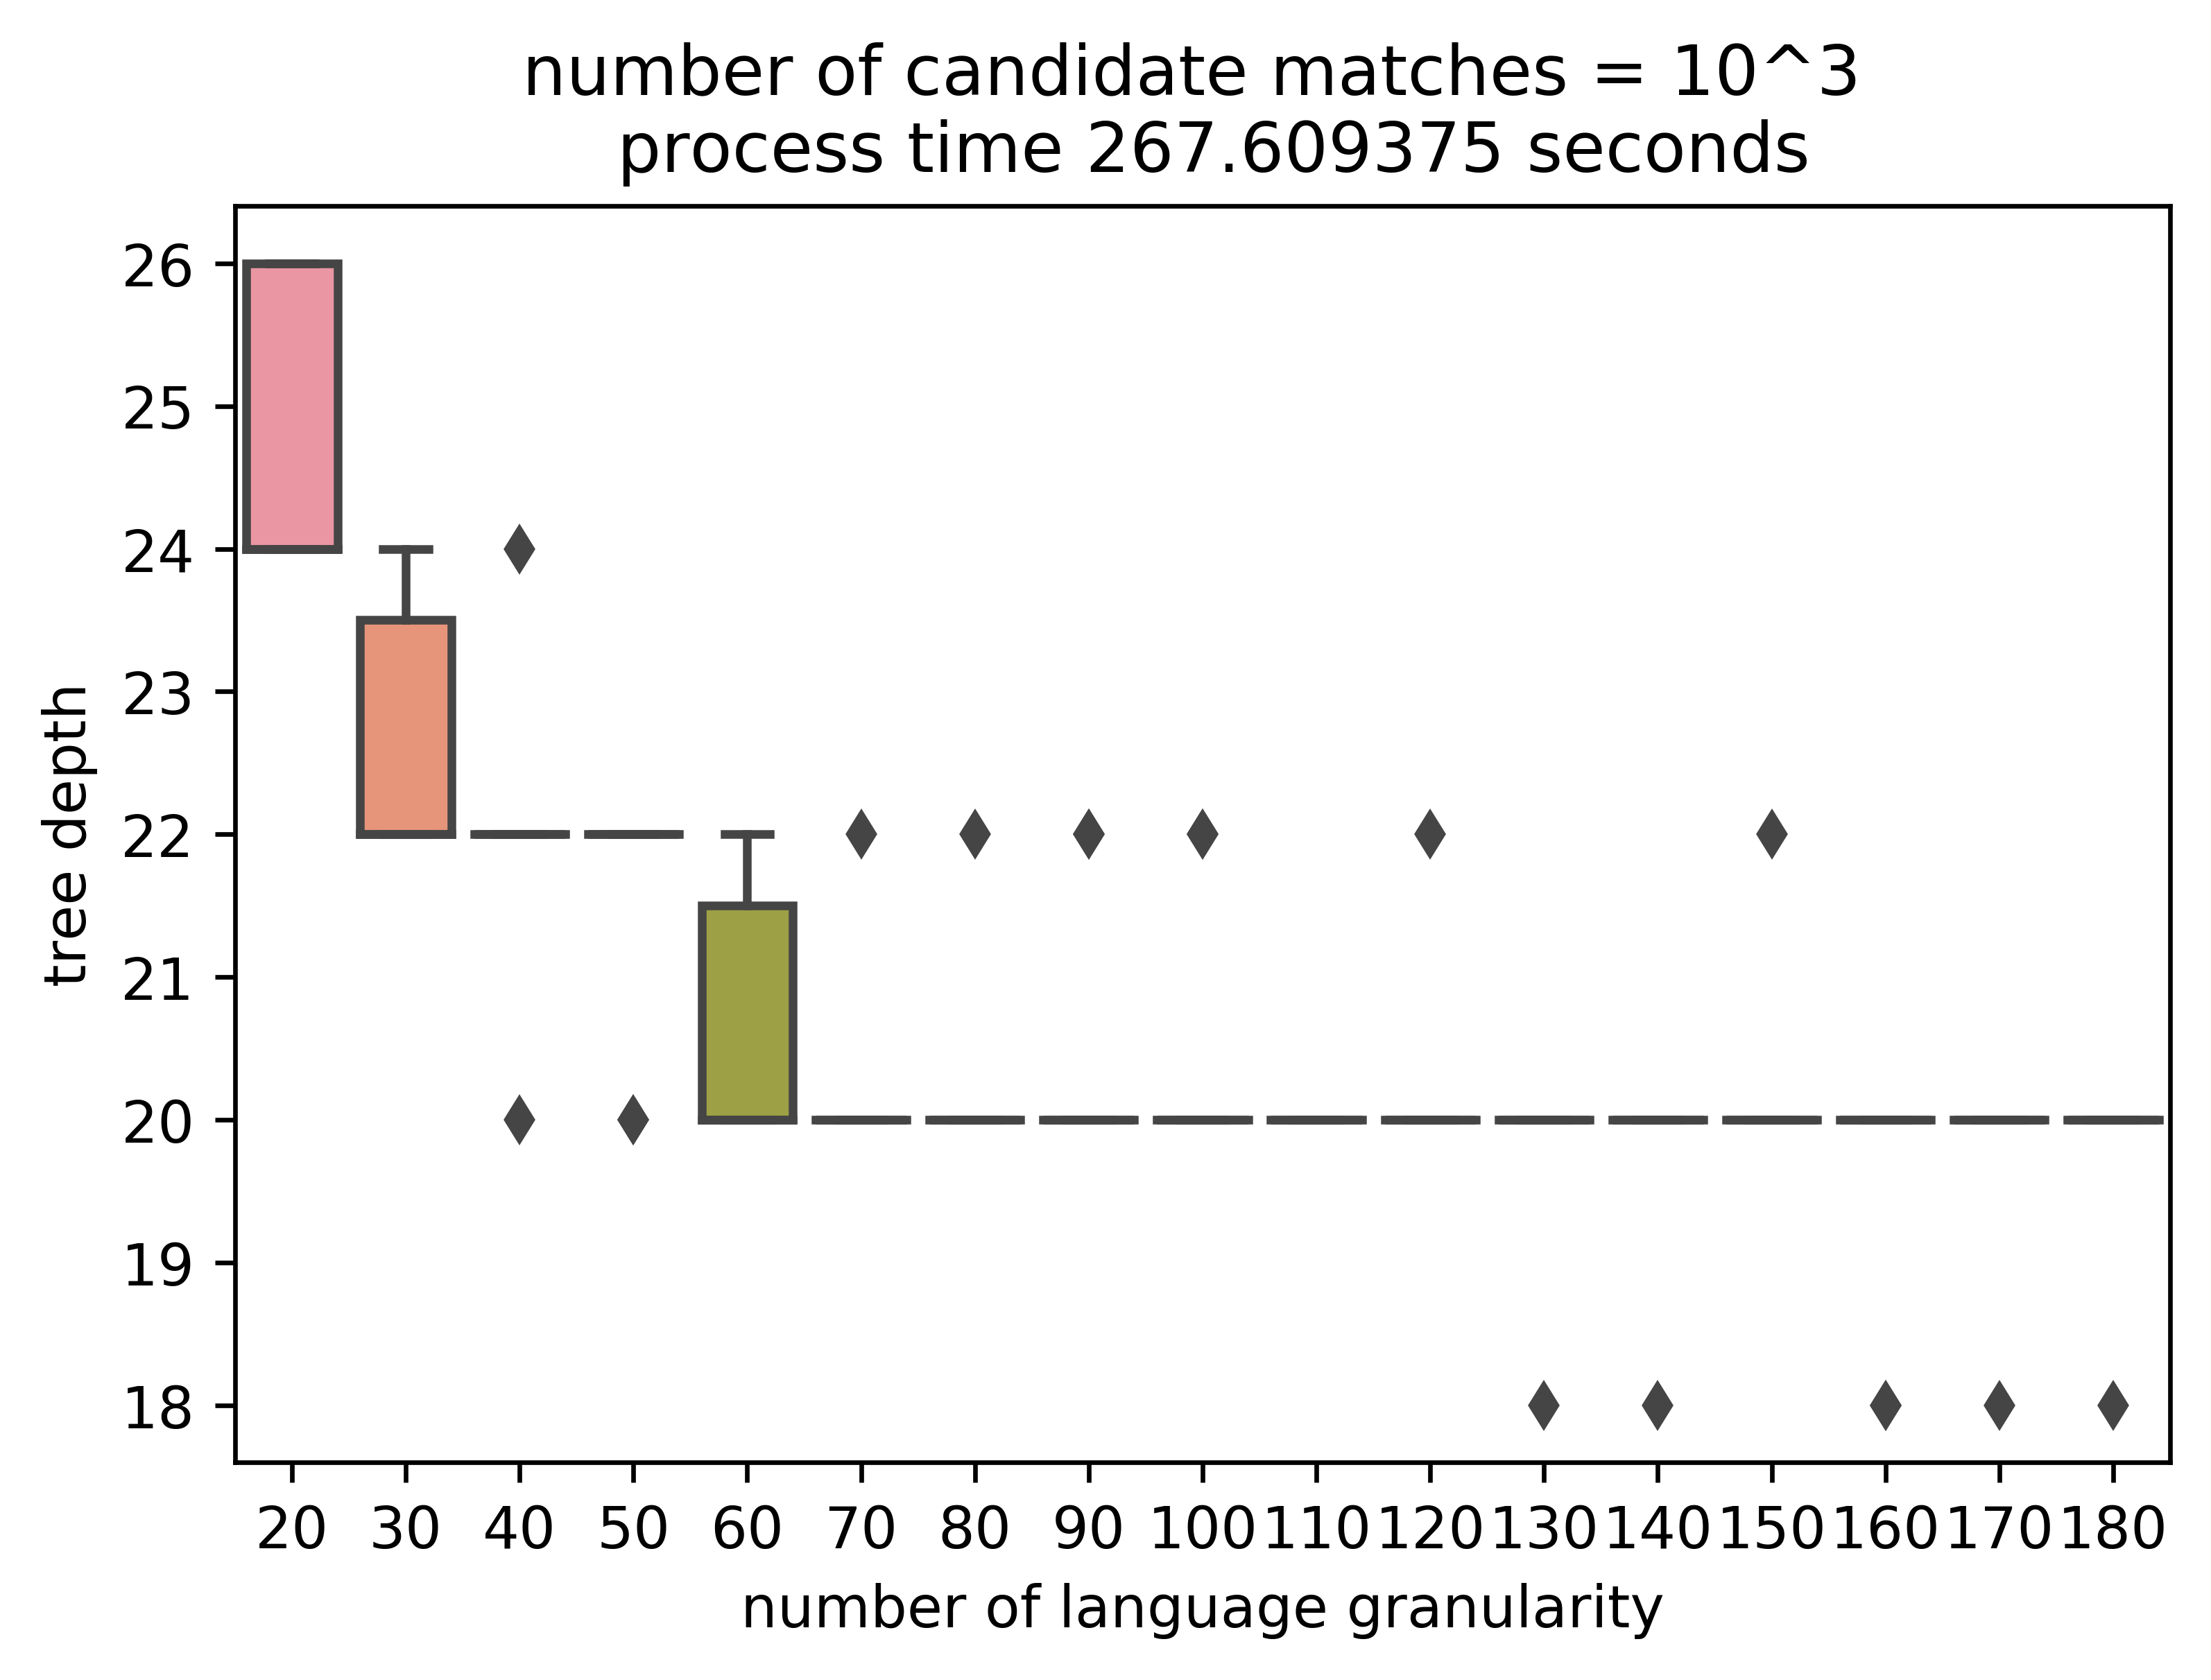

In [272]:
plt.figure(dpi = 600)
sns.boxplot( data = depth_collect.iloc[:,1:18] )
plt.xlabel('number of language granularity')
plt.ylabel('tree depth')
plt.title('number of candidate matches = 10^3 \n process time %f seconds' %sum(run_time))
plt.show()

## 给定候选匹配数量 = 10^4，语言粒度ncol递增

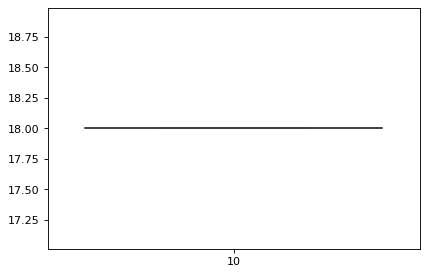

In [193]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 10

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect = depth_count

plt.figure(dpi = 80)
sns.boxplot( data = depth_collect )
plt.show()

end_time = time.process_time()
run_time = []
run_time.extend([end_time - start_time])

In [194]:
run_time

[10.3125]

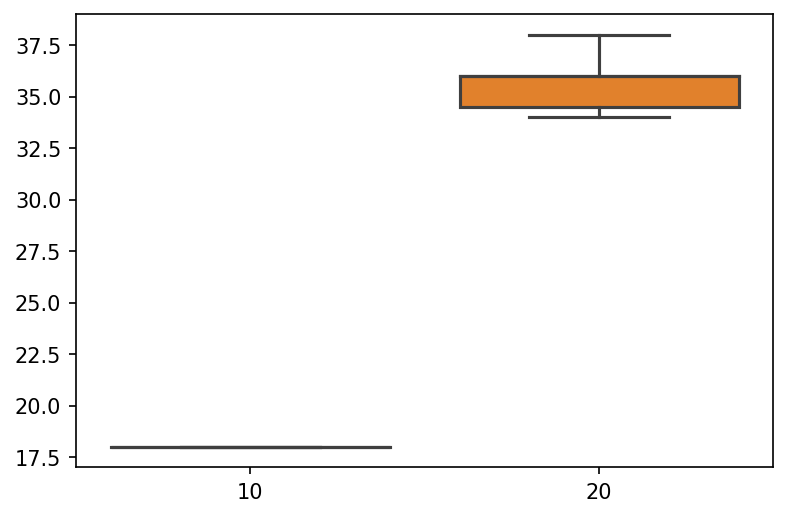

In [195]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 20

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 150)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

In [196]:
run_time

[10.3125, 26.640625]

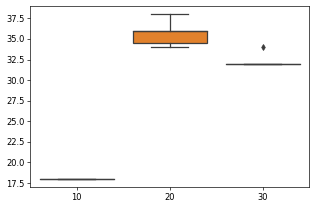

In [197]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 30

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

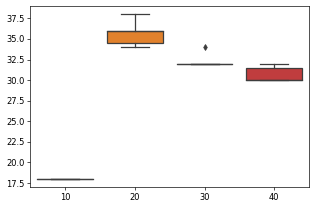

In [201]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 40

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

In [202]:
run_time

[10.3125, 26.640625, 44.890625, 62.71875]

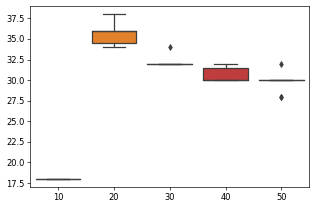

In [203]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 50

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

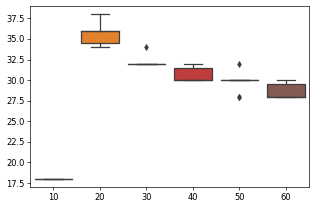

In [204]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 60

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

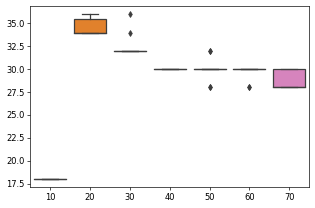

In [175]:
test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 70

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

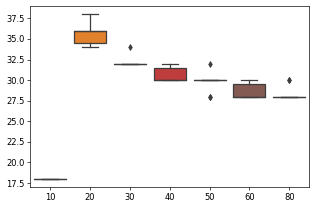

In [205]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 80

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

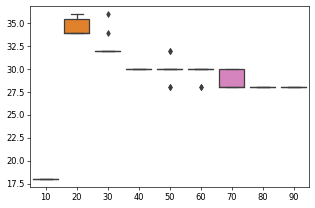

In [177]:
test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 90

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

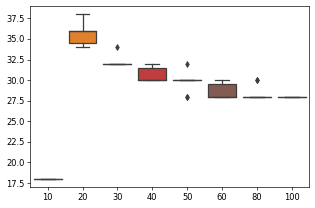

In [206]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 100

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

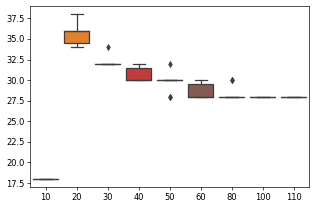

In [207]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 110

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

In [210]:
sum(run_time)/60

18.0109375

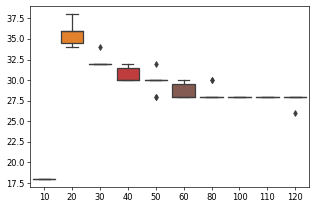

In [211]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 120

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

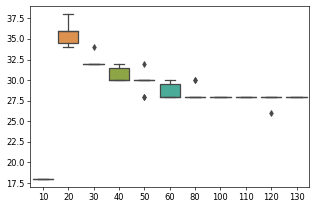

In [212]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 130

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

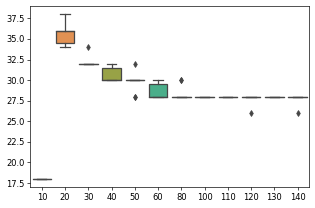

In [213]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 140

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

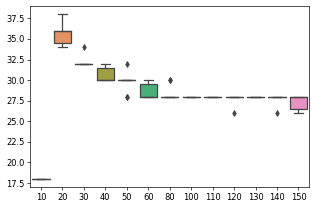

In [214]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 150

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

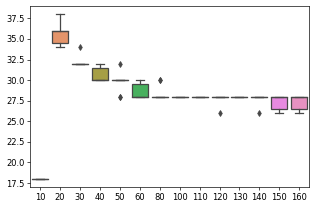

In [215]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 160

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

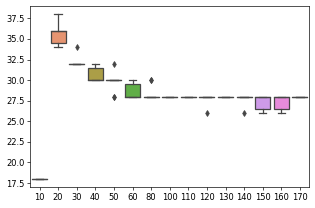

In [216]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 170

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

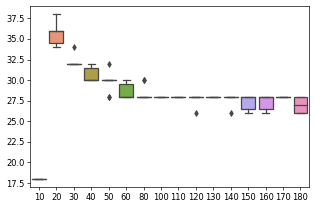

In [217]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10000
ncol = 180

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

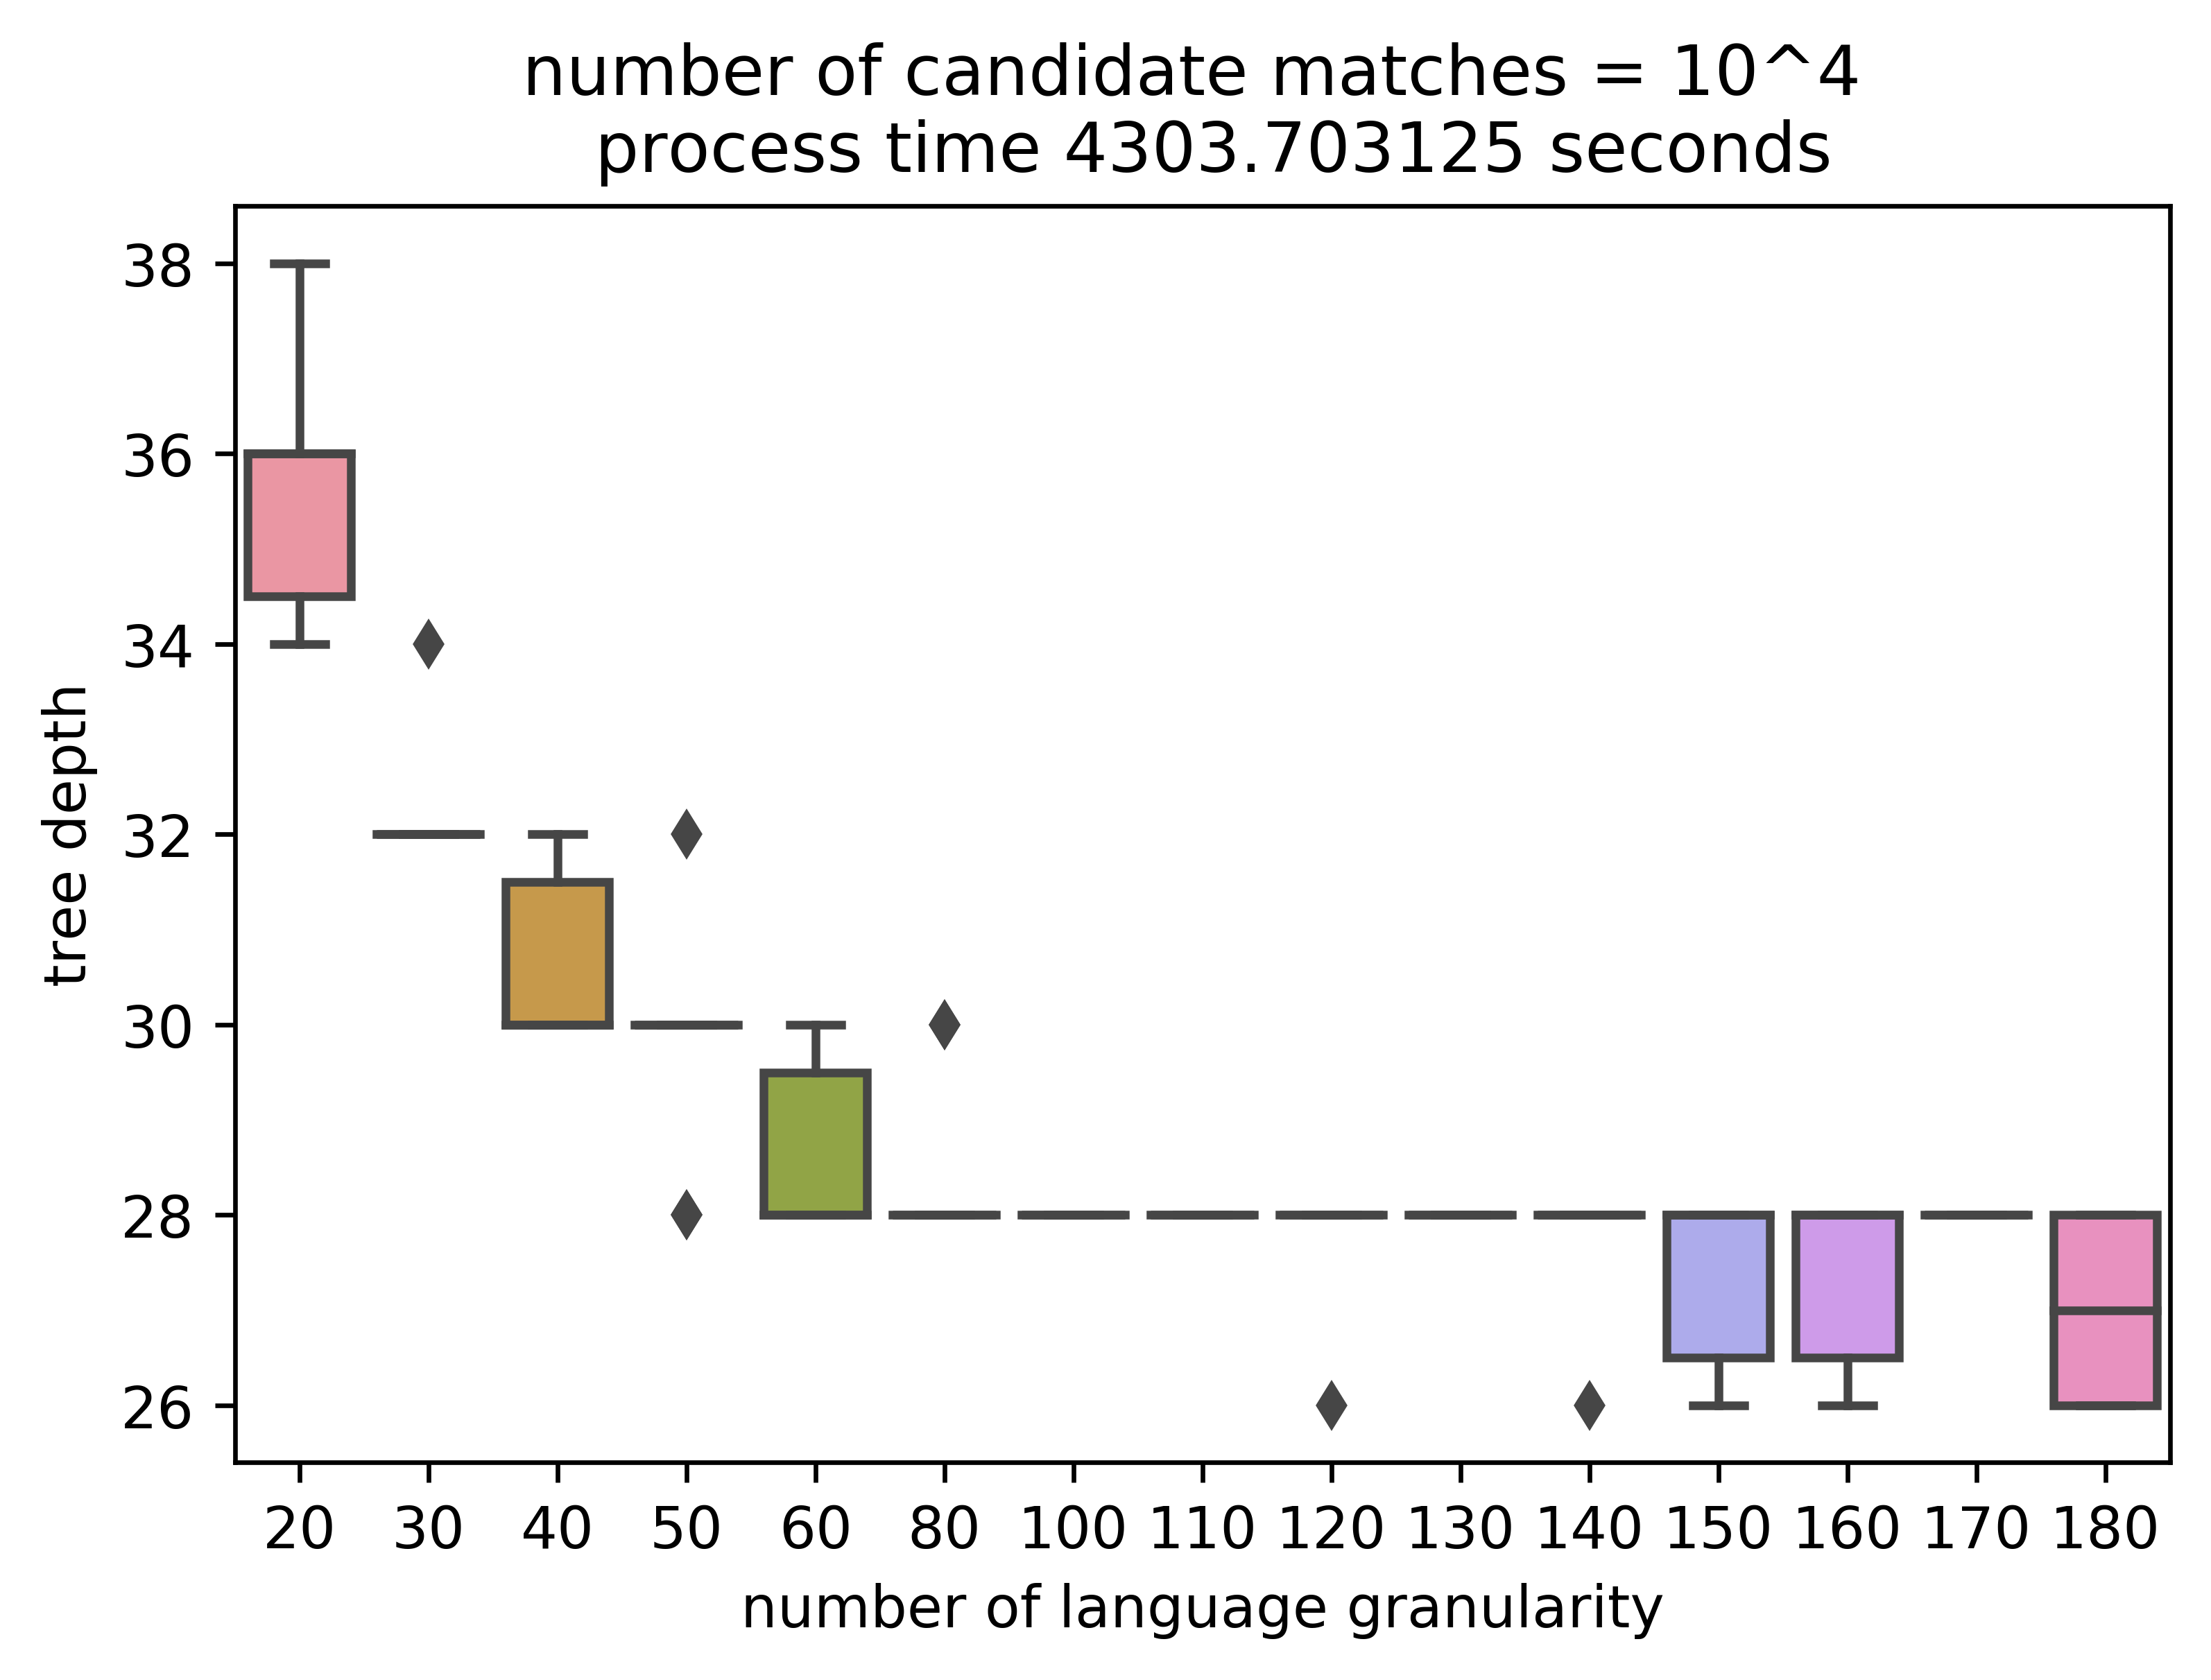

In [225]:
plt.figure(dpi = 600)
sns.boxplot( data = depth_collect.iloc[:,1:18] )
plt.xlabel('number of language granularity')
plt.ylabel('tree depth')
plt.title('number of candidate matches = 10^4 \n process time %f seconds' %sum(run_time))
plt.show()

In [221]:
sum(run_time)

4303.703125

## 给定候选匹配数量 = 10^5，语言粒度ncol递增

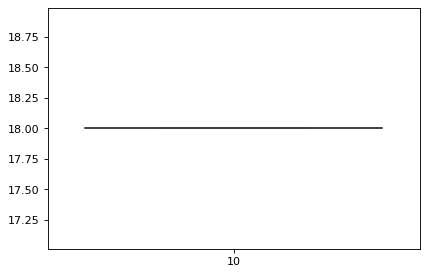

In [273]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**5
ncol = 10

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect = depth_count

plt.figure(dpi = 80)
sns.boxplot( data = depth_collect )
plt.show()

end_time = time.process_time()
run_time = []
run_time.extend([end_time - start_time])

In [274]:
run_time

[90.984375]

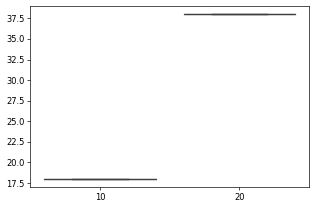

In [275]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**5
ncol = 20

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

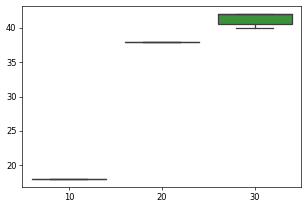

In [276]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**5
ncol = 30

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

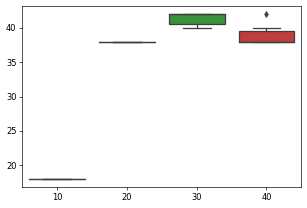

In [277]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**5
ncol = 40

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

In [278]:
run_time

[90.984375, 360.78125, 715.53125, 1049.140625]

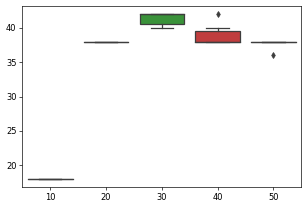

In [279]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**5
ncol = 50

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

In [280]:
run_time

[90.984375, 360.78125, 715.53125, 1049.140625, 1321.328125]

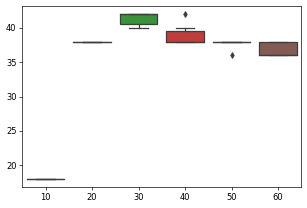

In [281]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**5
ncol = 60

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

In [282]:
run_time

[90.984375, 360.78125, 715.53125, 1049.140625, 1321.328125, 1773.90625]

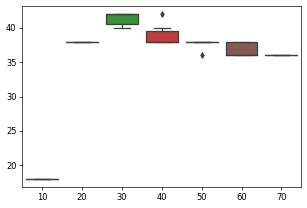

In [283]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**5
ncol = 70

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

In [284]:
run_time

[90.984375,
 360.78125,
 715.53125,
 1049.140625,
 1321.328125,
 1773.90625,
 2305.1875]

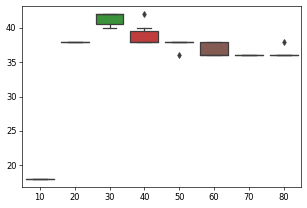

In [285]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**5
ncol = 80

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

In [286]:
run_time

[90.984375,
 360.78125,
 715.53125,
 1049.140625,
 1321.328125,
 1773.90625,
 2305.1875,
 2912.265625]

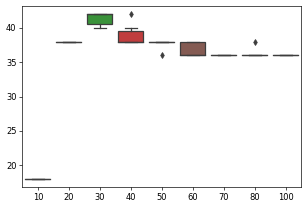

In [287]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**5
ncol = 100

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

In [288]:
run_time

[90.984375,
 360.78125,
 715.53125,
 1049.140625,
 1321.328125,
 1773.90625,
 2305.1875,
 2912.265625,
 3986.65625]

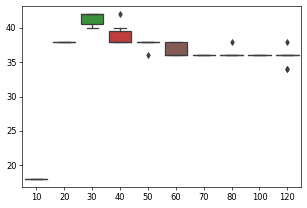

In [289]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**5
ncol = 120

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

In [291]:
run_time

[90.984375,
 360.78125,
 715.53125,
 1049.140625,
 1321.328125,
 1773.90625,
 2305.1875,
 2912.265625,
 3986.65625,
 5649.40625]

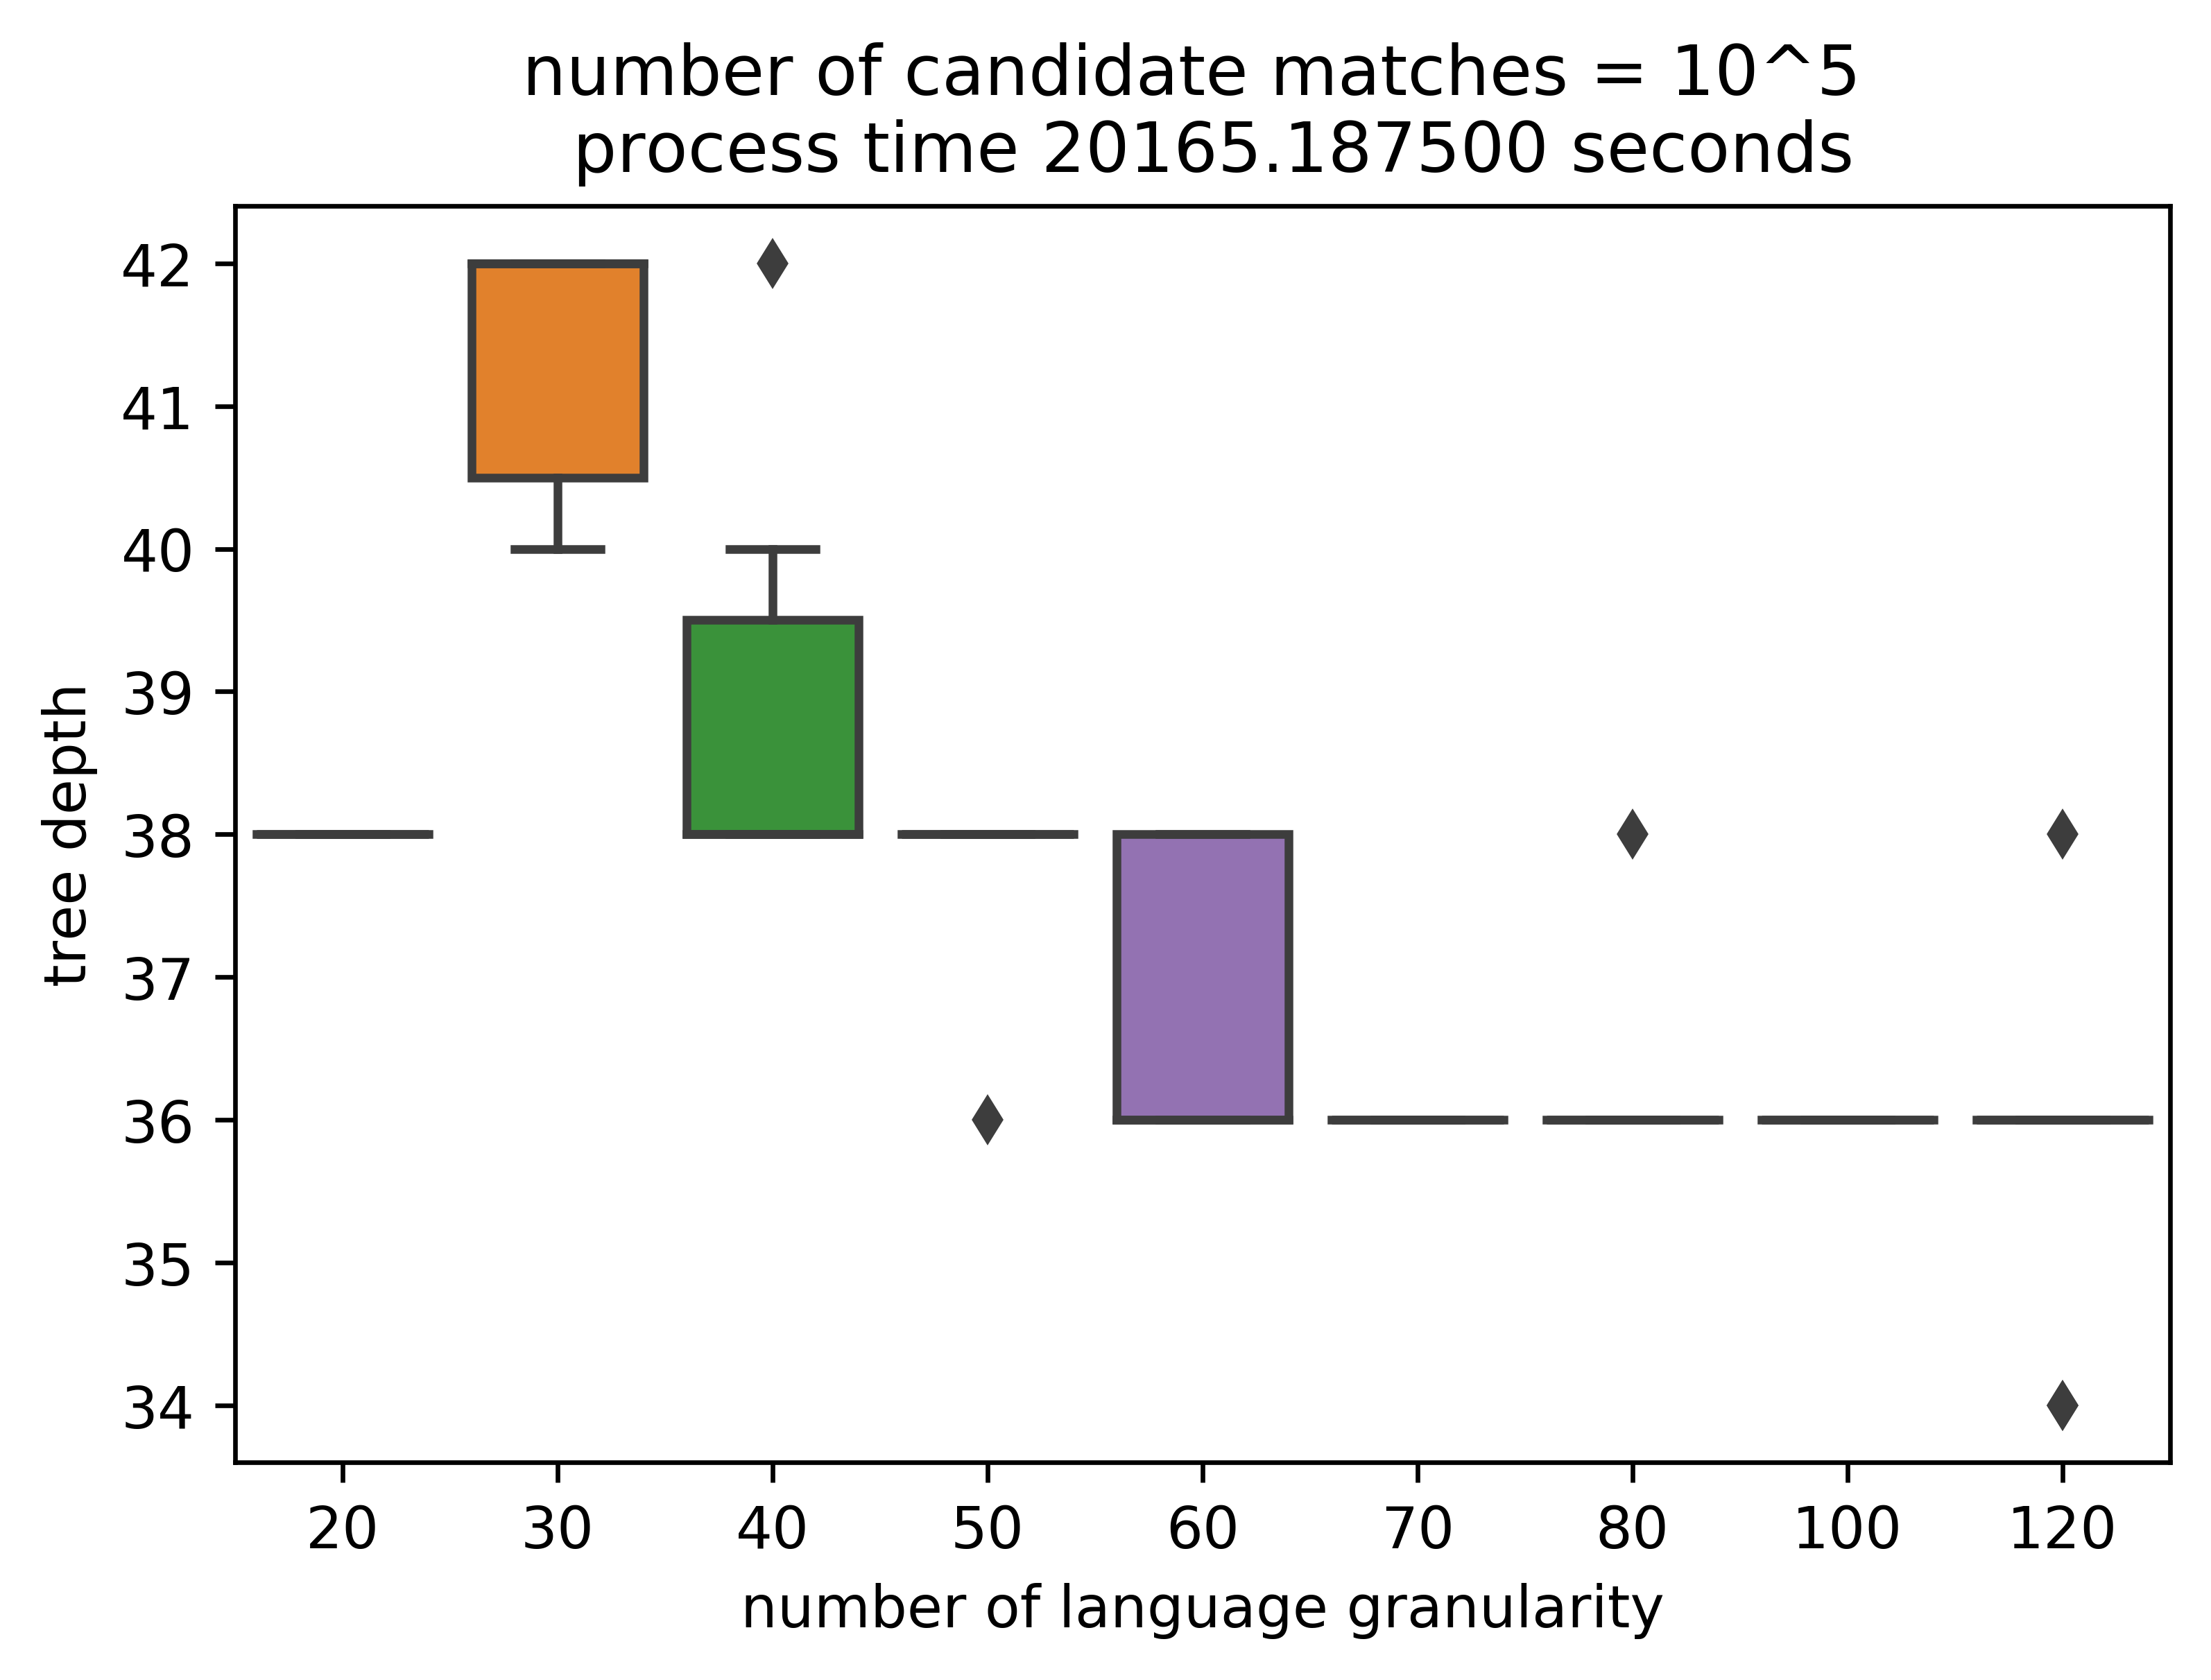

In [290]:
plt.figure(dpi = 600)
sns.boxplot( data = depth_collect.iloc[:,1:18] )
plt.xlabel('number of language granularity')
plt.ylabel('tree depth')
plt.title('number of candidate matches = 10^5 \n process time %f seconds' %sum(run_time))
plt.show()

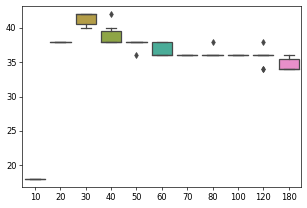

In [292]:
start_time = time.process_time()

test_time = 10

depth = pd.DataFrame(columns=[]) ## initialize dataframe
depth_count = pd.DataFrame(columns=[]) ## initialize dataframe

nrow = 10**5
ncol = 180

for test in range(test_time):
    try:
        myDat,labels = createDataSet(nrow,ncol)
        myTree = createTree(myDat,labels)
        depth.loc[nrow,ncol] = find_max_layer(myTree)
    except BaseException:
        depth.loc[nrow,ncol] = None
    depth_count = depth_count.append(depth)
depth_count.columns = [str(ncol)]
depth_count.index = [ np.arange(1,test_time+1)]
depth_collect =  pd.merge(depth_collect,depth_count,left_index=True,right_index = True, how = "outer" )

plt.figure(dpi = 60)
sns.boxplot( data = depth_collect )
# plt.xticks( np.arange(1,40,40))
plt.show()

end_time = time.process_time()
run_time.extend([end_time - start_time])

In [304]:
# depth_collect_10_5 = []
depth_collect_10_5 = depth_collect
depth_collect_10_5.to_csv('depth_collect_10_5.csv',index=False)

file = open('run_time_10_5.txt','w')
file.write(str(run_time))
file.close()

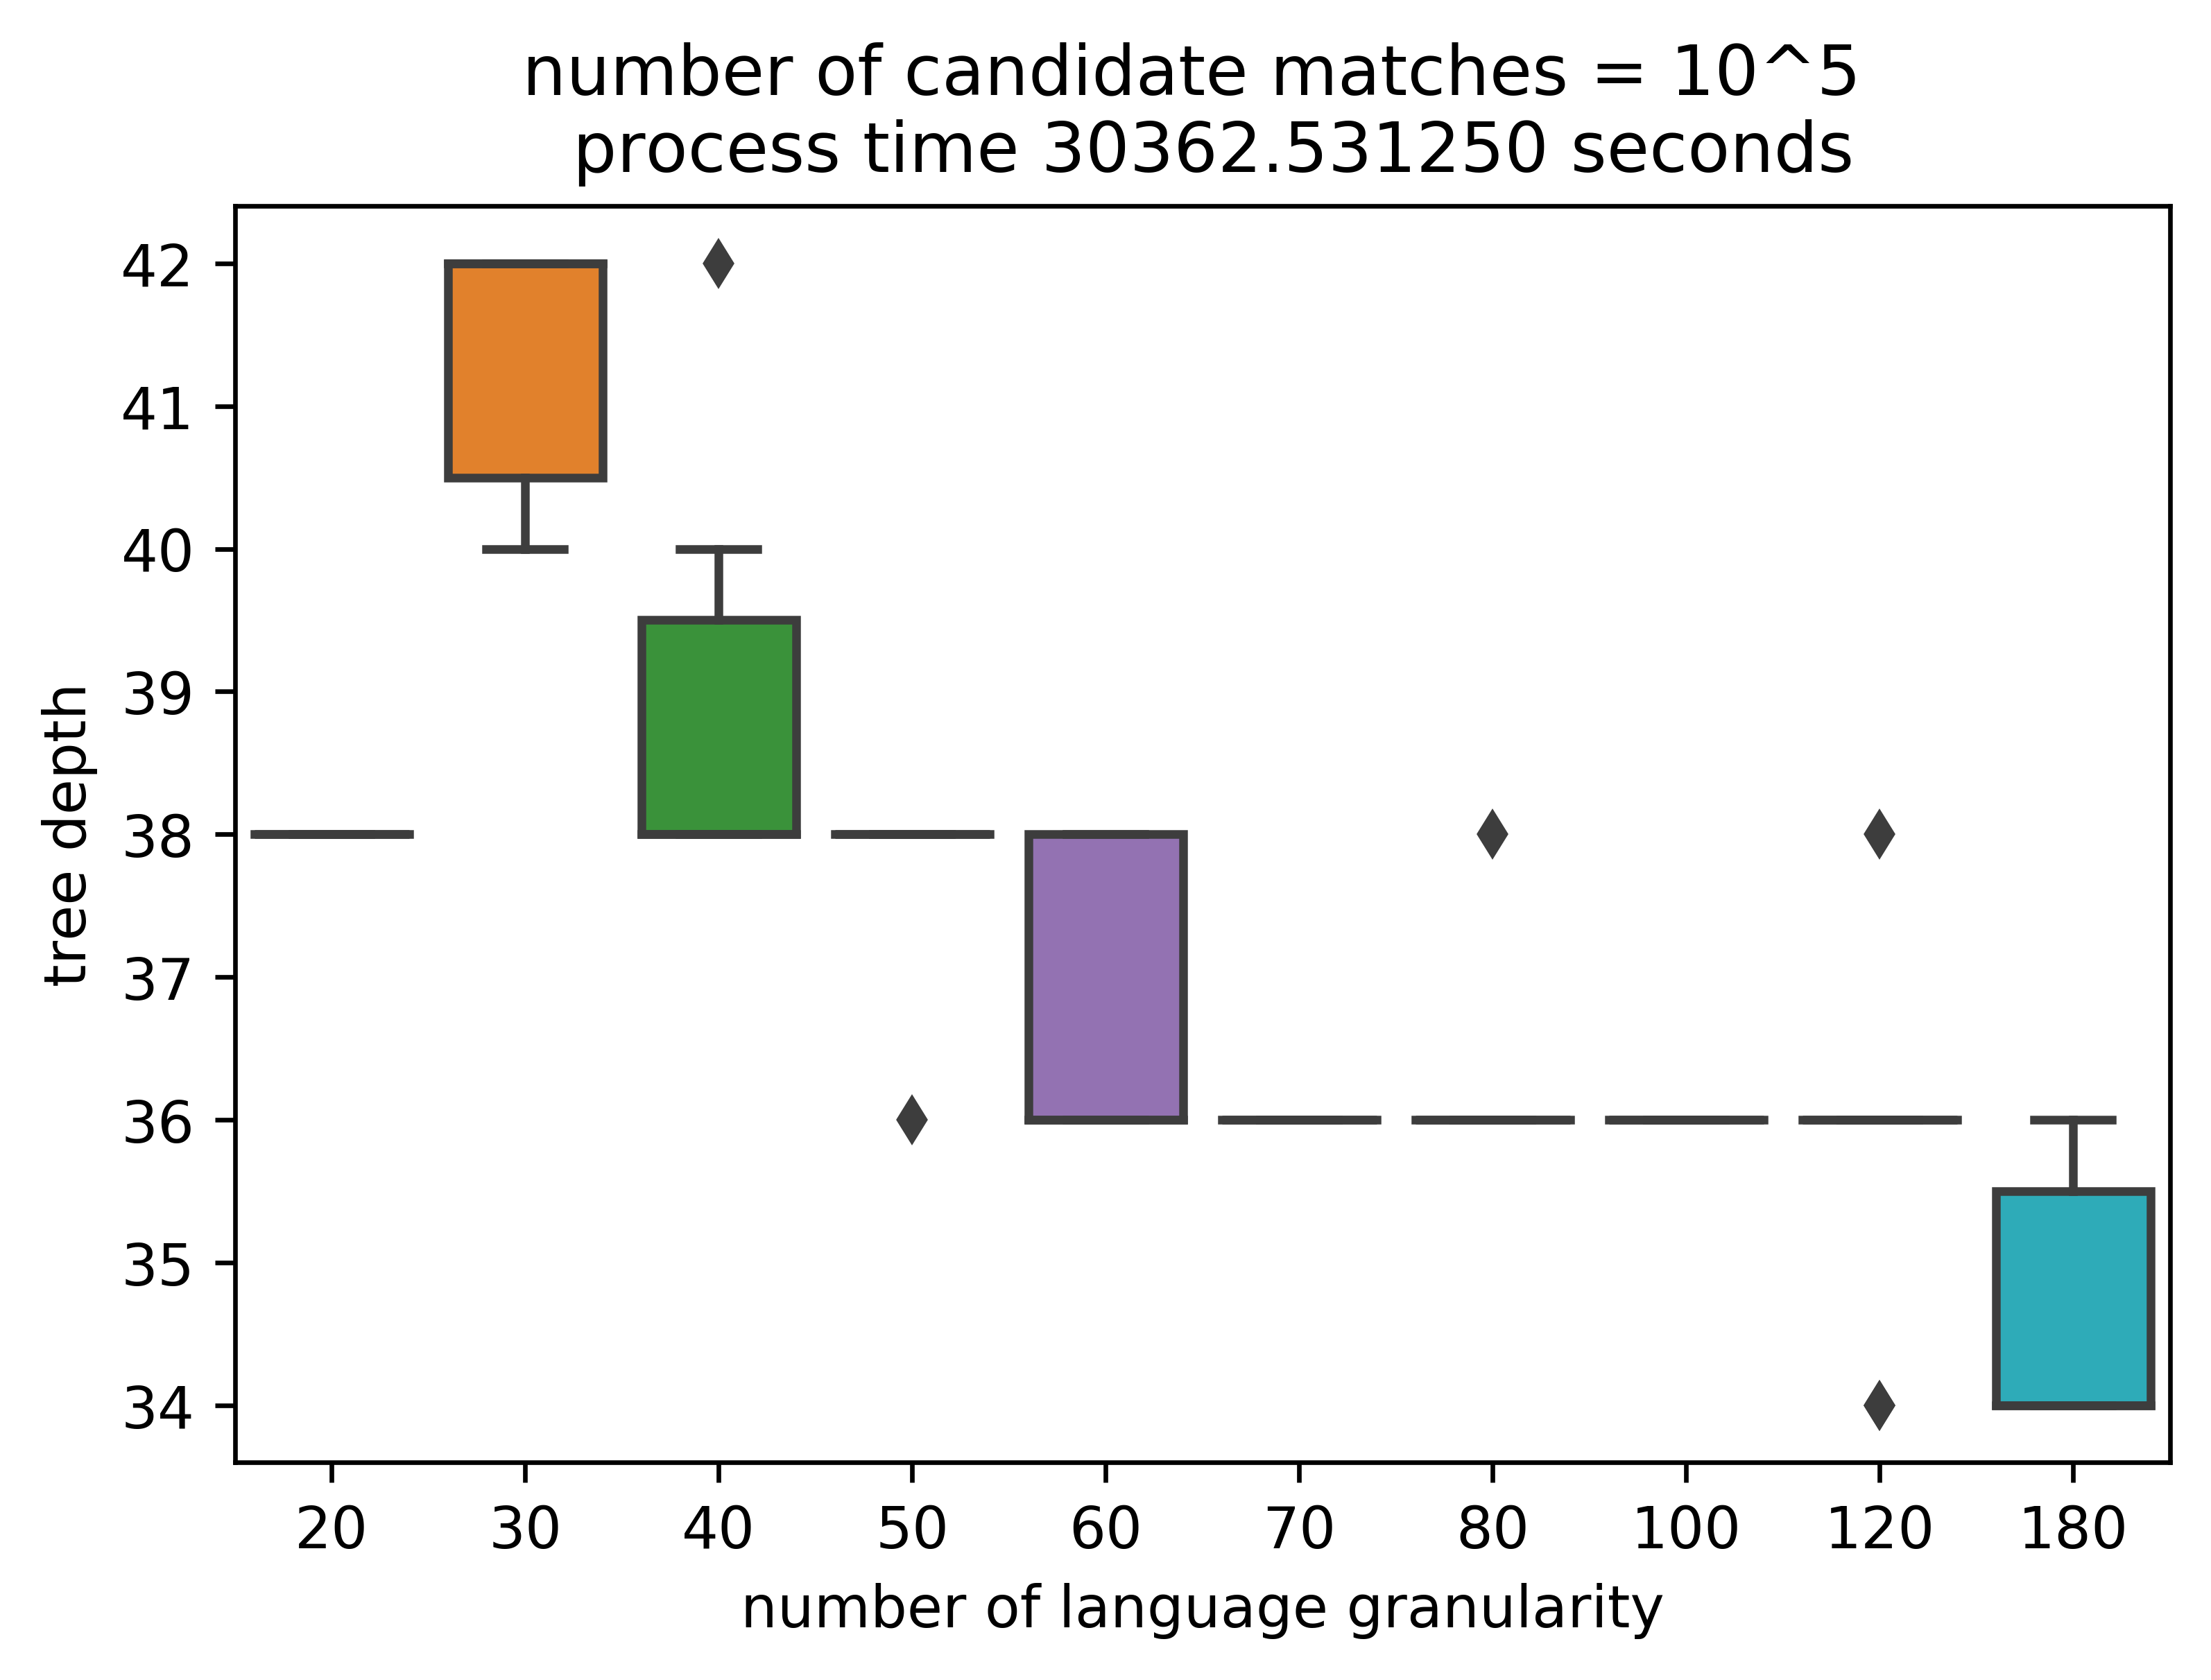

In [293]:
plt.figure(dpi = 600)
sns.boxplot( data = depth_collect.iloc[:,1:18] )
plt.xlabel('number of language granularity')
plt.ylabel('tree depth')
plt.title('number of candidate matches = 10^5 \n process time %f seconds' %sum(run_time))
plt.show()